# VAE

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
from fastprogress import progress_bar
from PIL import Image
import torchvision.transforms.functional as TF,torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.io import read_image, ImageReadMode
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.fid import *

In [ ]:
set_seed(1103, False)
mpl.rcParams['image.cmap'] = 'gray'
logging.disable(logging.WARNING)

In [ ]:
fm_x, fm_y = "image", "label"
name = "fashion_mnist"
ds = load_dataset(name)

In [ ]:
@inplace
def transformi(b):
    b[fm_x] = [TF.to_tensor(i).flatten() for i in b[fm_x]]
    b[fm_y] = b[fm_x]
    
dst = ds.with_transform(transformi)

bs = 128
dls = DataLoaders.from_dd(dst, bs)
xb, yb = next(iter(dls.train))

## Autoencoder

In [ ]:
xb.shape, yb.shape

(torch.Size([128, 784]), torch.Size([128, 784]))

In [ ]:
def lin(ni, nf, act=nn.SiLU, norm=nn.BatchNorm1d, bias=True):
    layers = [nn.Linear(ni, nf, bias=bias)]

    if act:
        layers.append(act())
    if norm:
        layers.append(norm(nf))

    return nn.Sequential(*layers)

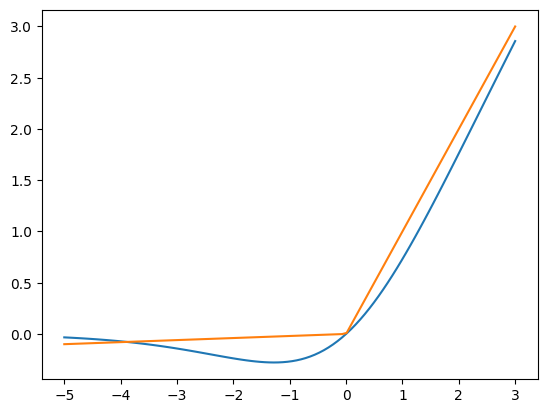

In [ ]:
x = torch.linspace(-5, 3, 100)
plt.plot(x, F.silu(x))
plt.plot(x, F.leaky_relu(x, 0.02))
plt.show()

In [ ]:
def init_weights(m, leak=0.03):
    if isinstance(m, nn.Linear):
        nonlin = "leaky_relu" if leak else "relu"
        init.kaiming_normal_(m.weight, nonlinearity=nonlin, a=leak)

In [ ]:
class Autoenc(nn.Module):
    def __init__(self, ni=784, nh=400, nf=200):
        super().__init__()

        self.down = nn.Sequential(
            lin(ni, nh), lin(nh, nh), lin(nh, nf)
        )
        self.up = nn.Sequential(
            lin(nf, nh), lin(nh, nh), lin(nh, ni, act=None)
        )

    def forward(self, x):
        return self.up(self.down(x))

In [ ]:
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB()]
opt_func = partial(optim.AdamW, eps=1e-4)

In [ ]:
yb.min(), yb.max()

(tensor(0.), tensor(1.))

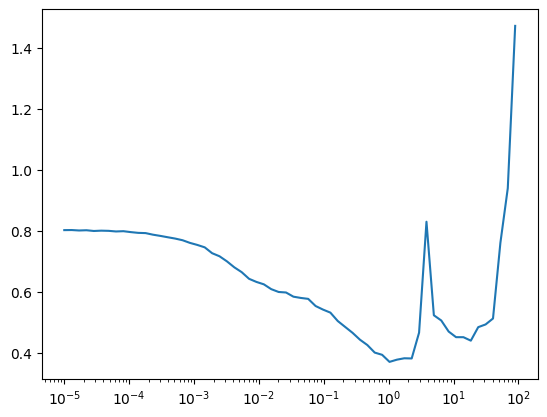

In [ ]:
set_seed(1103, False)
TrainLearner(Autoenc().apply(init_weights), dls, F.binary_cross_entropy_with_logits, lr=0.1, cbs=[DeviceCB()], opt_func=opt_func).lr_find()

loss,epoch,train
0.329,0,train
0.309,0,valid
0.299,1,train
0.297,1,valid
0.292,2,train
0.290,2,valid
0.288,3,train
0.287,3,valid
0.285,4,train
0.285,4,valid


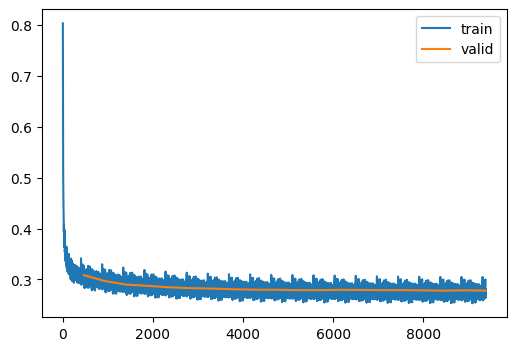

In [ ]:
set_seed(1103, False)
lr = 0.1
epochs = 20
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

model = Autoenc().apply(init_weights)

learn = TrainLearner(model, dls, F.binary_cross_entropy_with_logits, lr=lr, cbs=cbs, opt_func=opt_func)
learn.fit(epochs)

## Autoencoder Sample

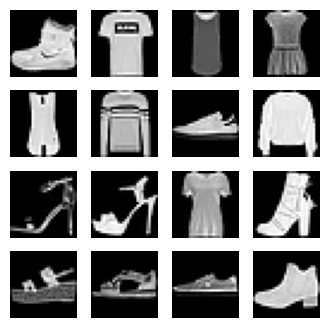

In [ ]:
show_images(yb[:16].reshape(-1, 1, 28, 28), imsize=1);

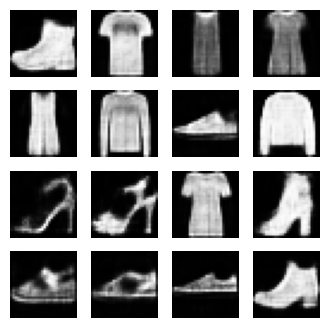

In [ ]:
with torch.no_grad():
    show_images(to_cpu(model(yb[:16].cuda()).sigmoid()).reshape(-1, 1, 28, 28), imsize=1);

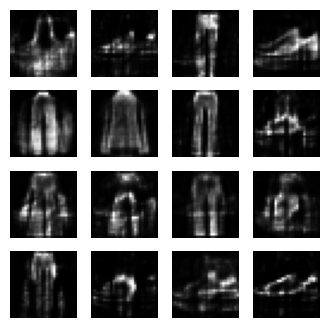

In [ ]:
set_seed(1103, False)
with torch.no_grad():
    show_images(to_cpu(model.up(torch.randn(16, 200).cuda()).sigmoid()).reshape(-1, 1, 28, 28), imsize=1);

# VAE

https://arxiv.org/abs/1312.6114

In [ ]:
class VAE(nn.Module):
    def __init__(self, ni=784, nh=400, nf=200):
        super().__init__()

        self.down = nn.Sequential(
            lin(ni, nh), lin(nh, nh), lin(nh, nf)
        )
        self.mu = lin(nf, nf, act=None)
        self.log_var = lin(nf, nf, act=None)
        self.up = nn.Sequential(
            lin(nf, nh), lin(nh, nh), lin(nh, ni, act=None)
        )

    def forward(self, x):
        x = self.down(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        x = mu + log_var.exp() * torch.randn_like(log_var)
        return self.up(x), mu, log_var

In [ ]:
preds = VAE()(xb[:4])
preds[0].shape

torch.Size([4, 784])

In [ ]:
def kld_loss(preds, expected):
    _, mu, log_var = preds
    return -0.5 * (1 + log_var - mu ** 2 - log_var.exp()).mean()

In [ ]:
kld_loss(preds, yb[:4]), kld_loss((preds[0], preds[1] * 0, preds[2] / preds[2]), yb[:4])

(tensor(0.8068, grad_fn=<MulBackward0>),
 tensor(0.3591, grad_fn=<MulBackward0>))

In [ ]:
def bce_loss(preds, expected):
    x = preds[0]
    return F.binary_cross_entropy_with_logits(x, expected)

In [ ]:
bce_loss(preds, yb[:4]), bce_loss((yb[:4],), yb[:4])

(tensor(0.8127, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 tensor(0.6613))

In [ ]:
def vae_loss(preds, expected):
    return kld_loss(preds, expected) + bce_loss(preds, expected)

In [ ]:
vae_loss(preds, yb[:4])

tensor(1.6194, grad_fn=<AddBackward0>)

In [ ]:
from torcheval.metrics import Mean

In [ ]:
class FuncMetric(Mean):
    def __init__(self, f):
        super().__init__()
        self.f = f

    def update(self, preds, expected):
        self.weighted_sum += self.f(preds, expected)
        self.weights += 1

In [ ]:
cbs[2] = MetricsCB(kld=FuncMetric(kld_loss), bce=FuncMetric(bce_loss))

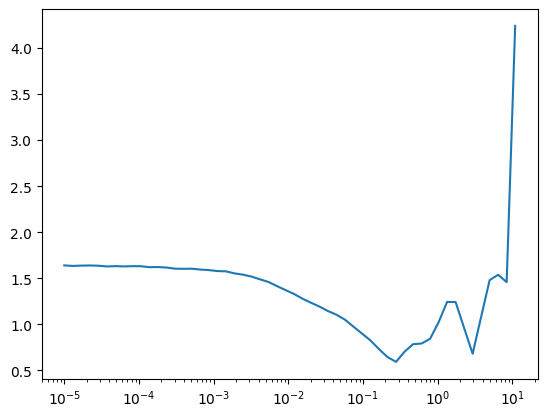

In [ ]:
set_seed(1103, False)
TrainLearner(VAE().apply(init_weights), dls, vae_loss, lr=0.1, cbs=[DeviceCB()], opt_func=opt_func).lr_find()

kld,bce,loss,epoch,train
0.028,0.367,0.394,0,train
0.019,0.333,0.352,0,valid
0.019,0.325,0.344,1,train
0.018,0.327,0.345,1,valid
0.019,0.322,0.341,2,train
0.018,0.322,0.341,2,valid
0.019,0.321,0.339,3,train
0.018,0.323,0.341,3,valid
0.019,0.320,0.339,4,train
0.019,0.325,0.344,4,valid


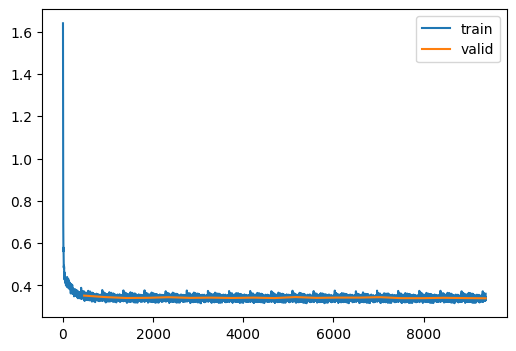

In [ ]:
set_seed(1103, False)
lr = 0.1
epochs = 20
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

model = VAE().apply(init_weights)

learn = TrainLearner(model, dls, vae_loss, lr=lr, cbs=cbs, opt_func=opt_func)
learn.fit(epochs)

## VAE sample

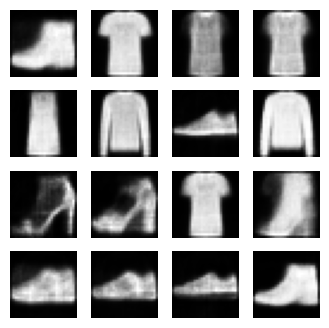

In [ ]:
with torch.no_grad():
    show_images(to_cpu(model(yb[:16].cuda())[0].sigmoid()).reshape(-1, 1, 28, 28), imsize=1);

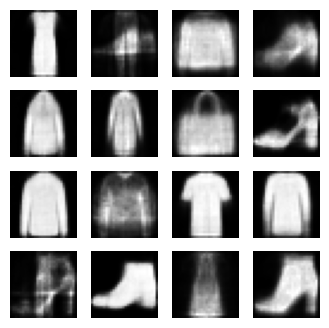

In [ ]:
set_seed(1103, False)
with torch.no_grad():
    show_images(to_cpu(model.up(torch.randn(16, 200).cuda()).sigmoid()).reshape(-1, 1, 28, 28), imsize=1);